# FP-Kecerdasan-Buatan

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

highest_accuracy1 = 0
highest_accuracy2 = 0

## Load Dataset

### Attribute Information:
1. Date : (DD/MM/YYYY) Day, month ('june' to 'september'), year (2012) Weather data observations
2. Temp : temperature noon (temperature max) in Celsius degrees: 22 to 42
3. RH : Relative Humidity in %: 21 to 90
4. Ws :Wind speed in km/h: 6 to 29
5. Rain: total day in mm: 0 to 16.8 FWI Components
6. Fine Fuel Moisture Code (FFMC) index from the FWI system: 28.6 to 92.5
7. Duff Moisture Code (DMC) index from the FWI system: 1.1 to 65.9
8. Drought Code (DC) index from the FWI system: 7 to 220.4
9. Initial Spread Index (ISI) index from the FWI system: 0 to 18.5
10. Buildup Index (BUI) index from the FWI system: 1.1 to 68
11. Fire Weather Index (FWI) Index: 0 to 31.1
12. Classes: two classes, namely fire and not fire

In [2]:
# Read fie csv
forest_df = pd.read_csv('./dataset/training.csv', header=[0])

# Drop kolom hari, bulan, dan tahun karena tidak dibutuhkan
clean_df = forest_df.drop(columns=["day", "month", "year"])
clean_df.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire


## Slice Dataset Into Data Training, Validation, and Test

In [3]:
samples_string = np.array(clean_df.drop(columns=['Classes']))

samples = []
for sample in samples_string:
    _ = []
    for attribute in sample:
        _.append(float(attribute))
    samples.append(_)

batch = np.array(samples)
print(batch)

# Variasi Data Training dan Testing 1
x_train1 = batch[:200]
x_validation1 = batch[:20]
x_test1 = batch[200:]

# Variasi Data Training dan Testing 1
x_train2 = batch[:122]
x_validation2 = batch[:20]
x_test2 = batch[122:]

[[29.  57.  18.  ...  1.3  3.4  0.5]
 [29.  61.  13.  ...  1.   3.9  0.4]
 [26.  82.  22.  ...  0.3  2.7  0.1]
 ...
 [27.  87.  29.  ...  0.4  3.4  0.2]
 [24.  54.  18.  ...  1.7  5.1  0.7]
 [24.  64.  15.  ...  1.2  4.8  0.5]]


## Classes

In [4]:
classes = np.array(clean_df['Classes'])

outputs = []
for item in classes:
    if(item.strip() == 'not fire'):
        outputs.append(0)
    elif(item.strip() == 'fire'):
        outputs.append(1)

y = np.array(outputs)
print(y)

# Variasi Data Training dan Testing 1
y_train1 = y[:200]
y_validation1 = y[:20]
y_test1 = y[200:]

# Variasi Data Training dan Testing 1
y_train2 = y[:122]
y_validation2 = y[:20]
y_test2 = y[122:]

[0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0
 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1
 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0]


## Neural Networks Class

In [5]:
# Layer Class
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        # Generate random weights
        self.weights = np.random.randn(n_inputs, n_neurons) / 100
        
        # Make array fill of zeros
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        # Keep input values
        self.inputs = inputs
        
        # dot product of input with weight plus bias
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        # Get derivative value of weight and bias
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        # Get input derivative
        self.dinputs = np.dot(dvalues, self.weights.T)


# Activation Function ReLU Class
class Activation_ReLU:
    def forward(self, inputs):
        # Keep input values
        self.inputs = inputs
        
        # ReLU function
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        # copy dvalues
        self.dinputs = dvalues.copy()
        
        # if inputs <= 0 then make it 0
        self.dinputs[self.inputs <= 0] = 0


# Activation Softmax Class
class Activation_Softmax:
    def forward(self, inputs):
        # Eksponensial dan Prevent Overflow
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        
        # Normalisasi
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        
        # produce probabilites distribution
        self.output = probabilities

    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)
        
        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(- 1, 1)
            
            # Calculate Jacobian matrix of the output and
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)


# Loss Class
class Loss:
    # Calculate loss
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        
        # Mean of losses
        data_loss = np.mean(sample_losses)
        return data_loss


# Categorical Cross Entropy Class
class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        
        # Clip to prevent -log(0) because it produces INF(infinite)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        
        # Number of labels in every sample
        labels = len(dvalues[0])

        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = - y_true / dvalues
        
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy ():
    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
        
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        
        # Set the output
        self.output = self.activation.output
        
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        
        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Sthocastic Gradient Descent
class Optimizer_SGD:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate
        
    # Update parameters
    def update_params(self, layer):
        layer.weights += - self.learning_rate * layer.dweights
        layer.biases += - self.learning_rate * layer.dbiases

## Model 1 (Hyperparameter HL 1)

1 Hidden Layer dengan 64 node

Training


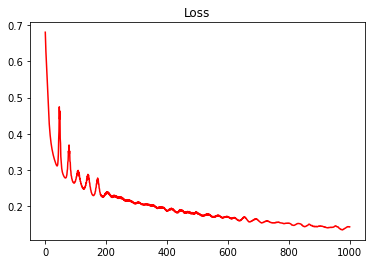

epoch: 1000, acc: 93.000%, loss: 14.288%

Testing
acc: 88.636%, loss: 28.197%


In [6]:
# Model
dense1 = Layer_Dense(10, 64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 2)

# loss and softmax activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Optimizer
optimizer = Optimizer_SGD(learning_rate=0.01)

# For loss history
log_loss = []

# Training
for epoch in range(1001):
    # Forwarding   
    dense1.forward(x_train1)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)

    # Calculate Loss
    loss = loss_activation.forward(dense2.output, y_train1)
    log_loss.append(loss)

    # Get y predictions
    y_pred = np.argmax(loss_activation.output, axis=1)

    # Calculate Accuracy
    if len(y_train1.shape) == 2:
        y_train = np.argmax(y_train1, axis=1)
    accuracy = np.mean(y_pred == y_train1)
    
    if accuracy > highest_accuracy1:
        highest_accuracy1 = accuracy
    
    # Backpropagation
    loss_activation.backward(loss_activation.output, y_train1)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)

print("Training")
# Visualization
plt.title('Loss')
plt.plot(log_loss, '-r')
plt.show()

# epoch, loss, acc
print(f'epoch: {epoch}, acc: {(accuracy * 100):.3f}%, loss: {(loss * 100):.3f}%')

# Testing
print("\nTesting")
# Forwarding   
dense1.forward(x_test1)
activation1.forward(dense1.output)
dense2.forward(activation1.output)

# Calculate Loss
loss = loss_activation.forward(dense2.output, y_test1)

# Get y predictions
y_pred = np.argmax(loss_activation.output, axis=1)

# Calculate Accuracy
if len(y_test1.shape) == 2:
    y_ = np.argmax(y_test1, axis=1)
accuracy = np.mean(y_pred == y_test1)

print(f'acc: {(accuracy * 100):.3f}%, loss: {(loss * 100):.3f}%')

## Model 2 (Hyperparameter HL 2)

2 Hidden Layer

Hidden layer 1 : 32 node

Hidden layer 2 : 16 node

Training


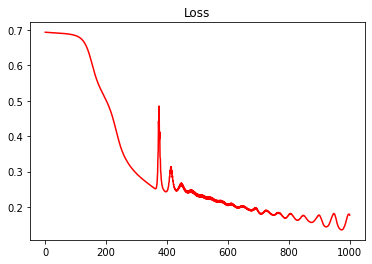

epoch: 1000, acc: 92.000%, loss: 17.723%

Testing
acc: 86.364%, loss: 32.862%


In [7]:
# Hidden Layer 1
dense1 = Layer_Dense(10, 32)
activation1 = Activation_ReLU()

# Hidden Layer 2
dense2 = Layer_Dense(32, 16)
activation2 = Activation_ReLU()

# Output Layer
dense3 = Layer_Dense(16, 2)

# loss and softmax activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Optimizer
optimizer = Optimizer_SGD(learning_rate=0.01)

# For loss history
log_loss = []

# Training
for epoch in range(1001):
    # Forwarding   
    dense1.forward(x_train1)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    
    # Calculate Loss
    loss = loss_activation.forward(dense3.output, y_train1)
    log_loss.append(loss)

    # Get y predictions
    y_pred = np.argmax(loss_activation.output, axis=1)

    # Calculate Accuracy
    if len(y_train1.shape) == 2:
        y_train = np.argmax(y_train1, axis=1)
    accuracy = np.mean(y_pred == y_train1)
    
    if accuracy > highest_accuracy1:
        highest_accuracy1 = accuracy
        
    # Backpropagation
    loss_activation.backward(loss_activation.output, y_train1)
    dense3.backward(loss_activation.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)

print("Training")
# Visualization
plt.title('Loss')
plt.plot(log_loss, '-r')
plt.show()

# epoch, loss, acc
print(f'epoch: {epoch}, acc: {(accuracy * 100):.3f}%, loss: {(loss * 100):.3f}%')

# Testing
print("\nTesting")
# Forwarding   
dense1.forward(x_test1)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)

# Calculate Loss
loss = loss_activation.forward(dense3.output, y_test1)

# Get y predictions
y_pred = np.argmax(loss_activation.output, axis=1)

# Calculate Accuracy
if len(y_test1.shape) == 2:
    y_ = np.argmax(y_test1, axis=1)
accuracy = np.mean(y_pred == y_test1)

print(f'acc: {(accuracy * 100):.3f}%, loss: {(loss * 100):.3f}%')

## Model 3 (Hyperparameter Variasi Data Training & Testing 1)

Data training: 200
Data Testing: 44

Training


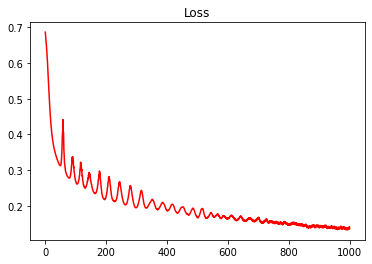

epoch: 1000, acc: 93.000%, loss: 13.681%

Testing
acc: 88.636%, loss: 27.505%


In [8]:
# Model
dense1 = Layer_Dense(10, 32)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(32, 2)

# loss and softmax activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Optimizer
optimizer = Optimizer_SGD(learning_rate=0.01)

# For loss history
log_loss = []

# Training
for epoch in range(1001):
    # Forwarding   
    dense1.forward(x_train1)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)

    # Calculate Loss
    loss = loss_activation.forward(dense2.output, y_train1)
    log_loss.append(loss)

    # Get y predictions
    y_pred = np.argmax(loss_activation.output, axis=1)

    # Calculate Accuracy
    if len(y_train1.shape) == 2:
        y_train = np.argmax(y_train1, axis=1)
    accuracy = np.mean(y_pred == y_train1)
    
    if accuracy > highest_accuracy2:
        highest_accuracy2 = accuracy
    
    # Backpropagation
    loss_activation.backward(loss_activation.output, y_train1)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)

print("Training")
# Visualization
plt.title('Loss')
plt.plot(log_loss, '-r')
plt.show()

# epoch, loss, acc
print(f'epoch: {epoch}, acc: {(accuracy * 100):.3f}%, loss: {(loss * 100):.3f}%')

# Testing
print("\nTesting")
# Forwarding   
dense1.forward(x_test1)
activation1.forward(dense1.output)
dense2.forward(activation1.output)

# Calculate Loss
loss = loss_activation.forward(dense2.output, y_test1)

# Get y predictions
y_pred = np.argmax(loss_activation.output, axis=1)

# Calculate Accuracy
if len(y_test1.shape) == 2:
    y_ = np.argmax(y_test1, axis=1)
accuracy = np.mean(y_pred == y_test1)

print(f'acc: {(accuracy * 100):.3f}%, loss: {(loss * 100):.3f}%')

## Model 4 (Hyperparameter Variasi Data Training & Testing 2)

Data training: 122
Data Testing: 122

Training


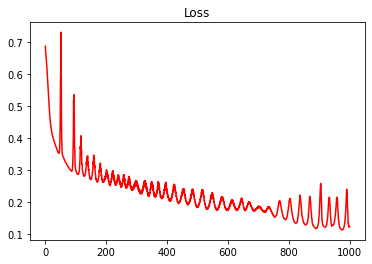

epoch: 1000, acc: 93.443%, loss: 12.376%

Testing
acc: 88.636%, loss: 21.080%


In [9]:
# Model
dense1 = Layer_Dense(10, 32)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(32, 2)

# loss and softmax activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Optimizer
optimizer = Optimizer_SGD(learning_rate=0.01)

# For loss history
log_loss = []

# Training
for epoch in range(1001):
    # Forwarding   
    dense1.forward(x_train2)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)

    # Calculate Loss
    loss = loss_activation.forward(dense2.output, y_train2)
    log_loss.append(loss)

    # Get y predictions
    y_pred = np.argmax(loss_activation.output, axis=1)

    # Calculate Accuracy
    if len(y_train2.shape) == 2:
        y_train = np.argmax(y_train1, axis=1)
    accuracy = np.mean(y_pred == y_train2)
    
    if accuracy > highest_accuracy2:
        highest_accuracy2 = accuracy
    
    # Backpropagation
    loss_activation.backward(loss_activation.output, y_train2)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)

print("Training")
# Visualization
plt.title('Loss')
plt.plot(log_loss, '-r')
plt.show()

# epoch, loss, acc
print(f'epoch: {epoch}, acc: {(accuracy * 100):.3f}%, loss: {(loss * 100):.3f}%')

# Testing
print("\nTesting")
# Forwarding   
dense1.forward(x_test1)
activation1.forward(dense1.output)
dense2.forward(activation1.output)

# Calculate Loss
loss = loss_activation.forward(dense2.output, y_test1)

# Get y predictions
y_pred = np.argmax(loss_activation.output, axis=1)

# Calculate Accuracy
if len(y_test1.shape) == 2:
    y_ = np.argmax(y_test1, axis=1)
accuracy = np.mean(y_pred == y_test1)

print(f'acc: {(accuracy * 100):.3f}%, loss: {(loss * 100):.3f}%')

In [10]:
print(f'Akurasi tertinggi dengan hyper parameter 1: {(highest_accuracy1 * 100):.3f}%')
print(f'Akurasi tertinggi dengan hyper parameter 2: {(highest_accuracy2 * 100):.3f}%')

if highest_accuracy1 > highest_accuracy2:
    print(f'Akurasi Tertinggi = {(highest_accuracy1 * 100):.3f}%')
else:
    print(f'Akurasi Tertinggi = {(highest_accuracy2 * 100):.3f}%')

Akurasi tertinggi dengan hyper parameter 1: 94.500%
Akurasi tertinggi dengan hyper parameter 2: 95.902%
Akurasi Tertinggi = 95.902%
